In [1]:
import xarray as xr
import numpy as np
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


# 数据展示

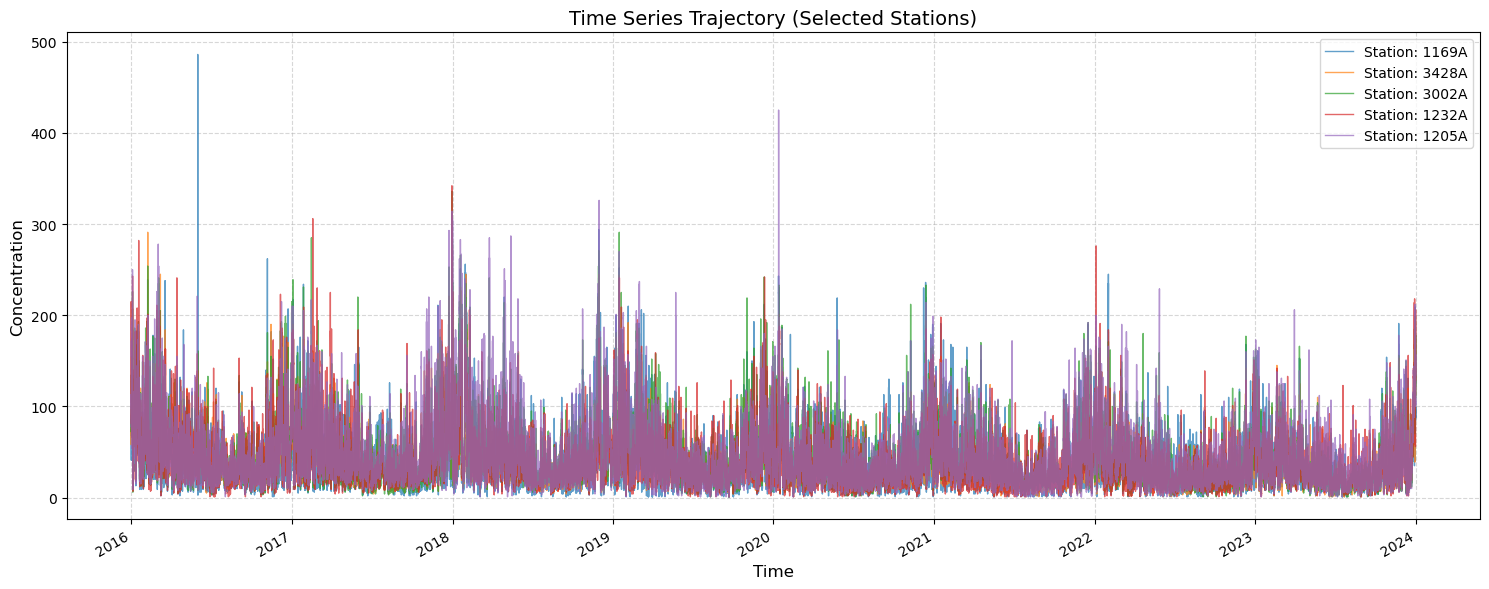

In [4]:
import matplotlib.pyplot as plt

num_stations_to_plot = 5
pm25 = ds['PM2.5']
o3 = ds['O3']
times = ds['time'].values
stations = ds['station'].values

np.random.seed(42)
selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# # 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
# selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data_o3 = o3.isel(station=idx).values
    station_data_pm25 = pm25.isel(station=idx).values
    
    plt.plot(times, station_data_pm25, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 算法处理

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations, fit_sindy_sr3_robust, lift_time_delay, plot_station
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [6]:
x_data = np.column_stack((pm25.values, o3.values))
df = pd.read_csv('../data_generators/stations_yrd.csv')
micro_name0 = list(df["station_id"]) * 2
micro_name1 = ['_pm25'] * 127 + ['_o3'] * 127
micro_name = [a + b for a, b in zip(micro_name0, micro_name1)]
x_data.shape

(70128, 254)

In [7]:
ide = ps.IdentityLibrary()
n_delays = 2
delay_interval = 24
H, new_names = lift_time_delay(x_data, feature_names=micro_name, n_delays=n_delays, delay_interval=delay_interval)
H.shape, new_names

((70080, 762),
 ['1141A_pm25',
  '1142A_pm25',
  '1143A_pm25',
  '1144A_pm25',
  '1145A_pm25',
  '1147A_pm25',
  '1148A_pm25',
  '1149A_pm25',
  '1150A_pm25',
  '1151A_pm25',
  '1152A_pm25',
  '1153A_pm25',
  '1154A_pm25',
  '1155A_pm25',
  '1156A_pm25',
  '1157A_pm25',
  '1158A_pm25',
  '1159A_pm25',
  '1160A_pm25',
  '1162A_pm25',
  '1163A_pm25',
  '1164A_pm25',
  '1165A_pm25',
  '1166A_pm25',
  '1167A_pm25',
  '1168A_pm25',
  '1169A_pm25',
  '1170A_pm25',
  '1171A_pm25',
  '1172A_pm25',
  '1186A_pm25',
  '1188A_pm25',
  '1189A_pm25',
  '1190A_pm25',
  '1191A_pm25',
  '1192A_pm25',
  '1193A_pm25',
  '1194A_pm25',
  '1195A_pm25',
  '1196A_pm25',
  '1200A_pm25',
  '1201A_pm25',
  '1203A_pm25',
  '1204A_pm25',
  '1205A_pm25',
  '1206A_pm25',
  '1207A_pm25',
  '1209A_pm25',
  '1223A_pm25',
  '1224A_pm25',
  '1226A_pm25',
  '1227A_pm25',
  '1228A_pm25',
  '1230A_pm25',
  '1231A_pm25',
  '1232A_pm25',
  '1233A_pm25',
  '1234A_pm25',
  '1235A_pm25',
  '1236A_pm25',
  '1239A_pm25',
  '1240A_

In [8]:
discrete_time = True
dt = 1
thresholds = np.logspace(-7, 2, 5)
model, results = fit_sindy_sr3_robust(H, ide, new_names, penalty='l1', discrete_time=discrete_time, max_iter=300, thresholds=thresholds, metric='bic', tol=1e-3, nu=10)

开始使用 L1 范数扫描 5 个参数...


100%|██████████| 5/5 [35:53<00:00, 430.63s/it]



最佳模型 (bic) | Penalty: l1
Param (Thr/Lam): 5.623e-01
Test MSE: 9.6010e+01
Complexity: 77021
(1141A_pm25)[k+1] = 0.554 1141A_pm25[k] + 0.068 1143A_pm25[k] + 0.086 1145A_pm25[k] + 0.052 1147A_pm25[k] + 0.024 1148A_pm25[k] + 0.009 1164A_pm25[k] + 0.020 1166A_pm25[k] + 0.018 1167A_pm25[k] + 0.036 1169A_pm25[k] + 0.022 1171A_pm25[k] + -0.012 1191A_pm25[k] + -0.031 1193A_pm25[k] + 0.013 1200A_pm25[k] + 0.010 1201A_pm25[k] + -0.022 1233A_pm25[k] + 0.073 3265A_pm25[k] + 0.027 3266A_pm25[k] + 0.029 3268A_pm25[k] + -0.025 1141A_o3[k] + -0.028 1143A_o3[k] + 0.045 1149A_o3[k] + 0.007 1157A_o3[k]
(1142A_pm25)[k+1] = 0.624 1142A_pm25[k] + 0.058 1143A_pm25[k] + 0.111 1145A_pm25[k] + 0.019 1147A_pm25[k] + 0.030 1148A_pm25[k] + 0.001 1149A_pm25[k] + 0.031 1150A_pm25[k] + -0.021 1163A_pm25[k] + 0.041 1166A_pm25[k] + 0.031 1169A_pm25[k] + 0.014 1171A_pm25[k] + -0.019 1193A_pm25[k] + 0.018 1201A_pm25[k] + -0.017 1233A_pm25[k] + 0.005 1241A_pm25[k] + 0.026 3265A_pm25[k] + 0.028 3266A_pm25[k] + -0.009 1143A

In [9]:
for r in results:
    print('thr', r['thr'])
    print('mse', r['mse'])
    print('score', r['score'])
    
model.score(H, t=dt)

thr 0.5623413251903491
mse 96.00960091960815
score 799368.3335814292
thr 0.0031622776601683794
mse 97.40688658225781
score 5477944.581831898
thr 1.778279410038923e-05
mse 97.40698139036577
score 5603003.707616932
thr 1e-07
mse 97.40669975402852
score 5603261.46187186
thr 100.0
mse 4127.040958833945
score inf


0.9355737541532072

In [29]:
model = results[1]['model']
model.score(H, t=dt)

0.9376174464674796

In [30]:
step_pred = 5
t = range(step_pred)
init_data = H[0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(5, 762)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_12139/2734313379.py:8: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



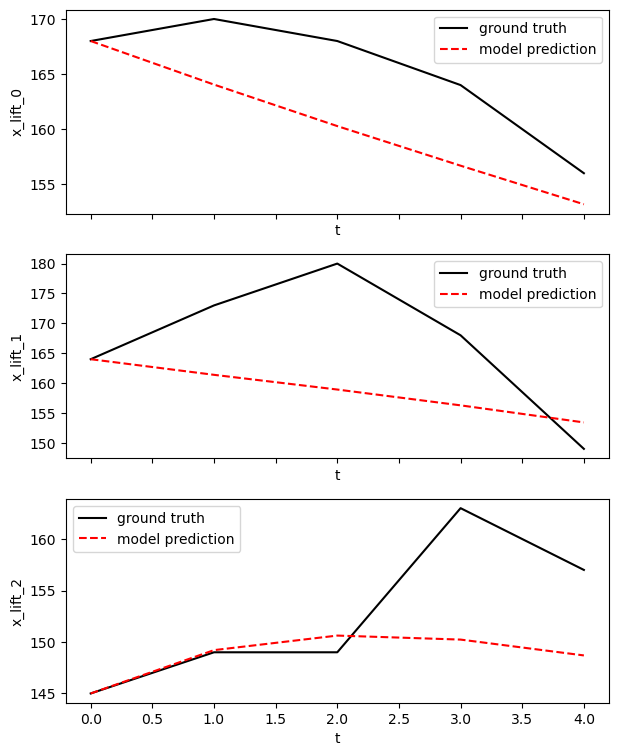

In [31]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(H[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

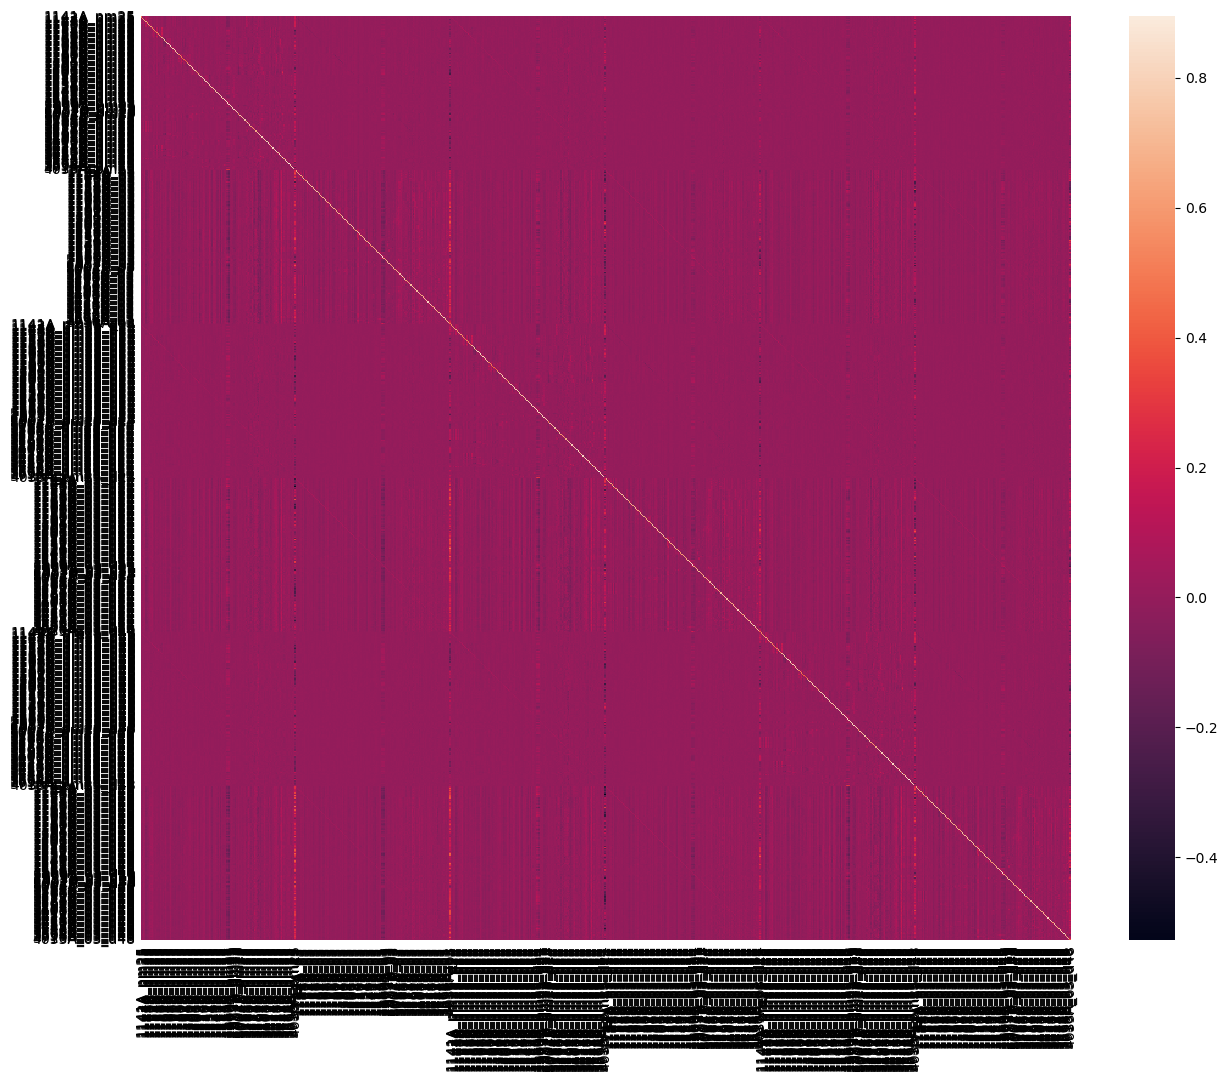

In [32]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=new_names, yticklabels=new_names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

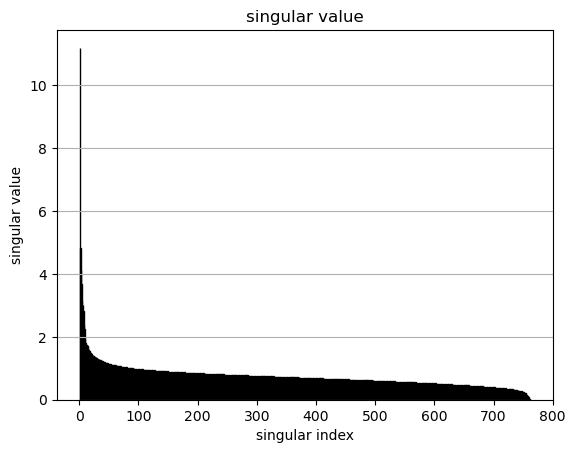

In [33]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

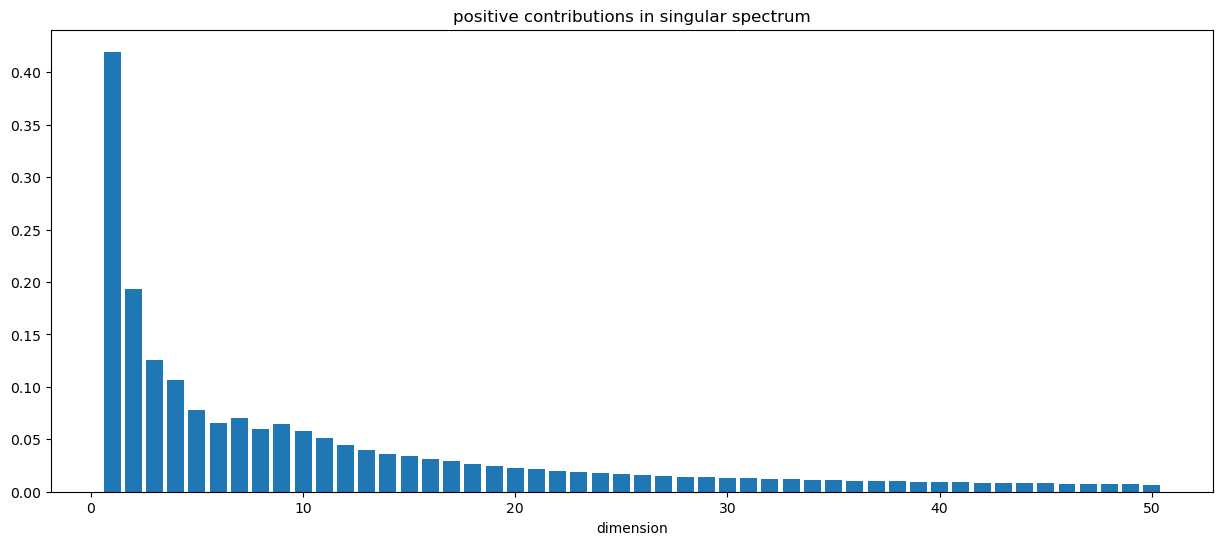

In [34]:
diff = get_positive_contributions(S)
diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [35]:
print(compute_entropy(diff))

4.643033211524037


In [36]:
rank = 2
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

7.2616357044649105


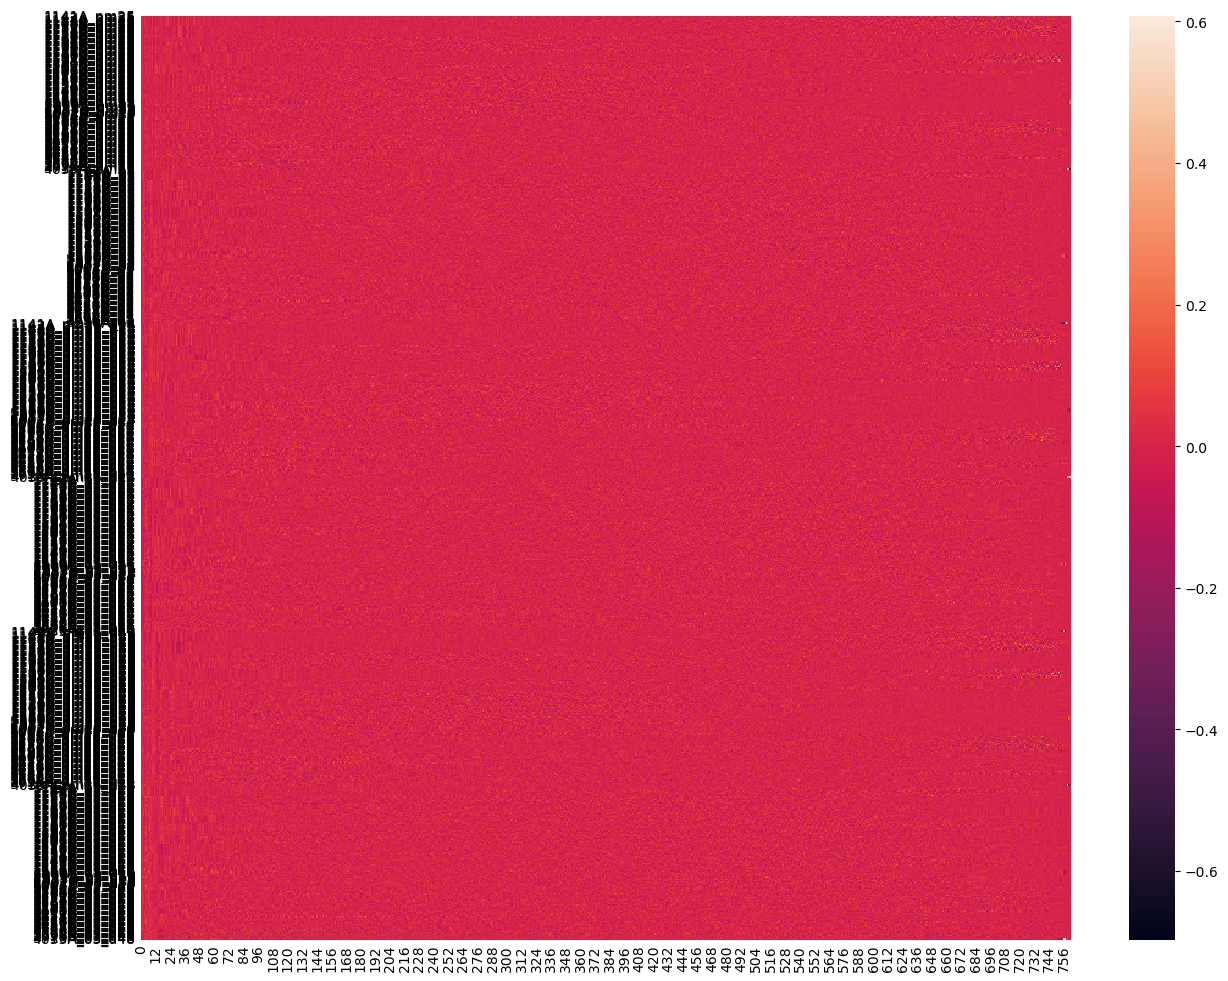

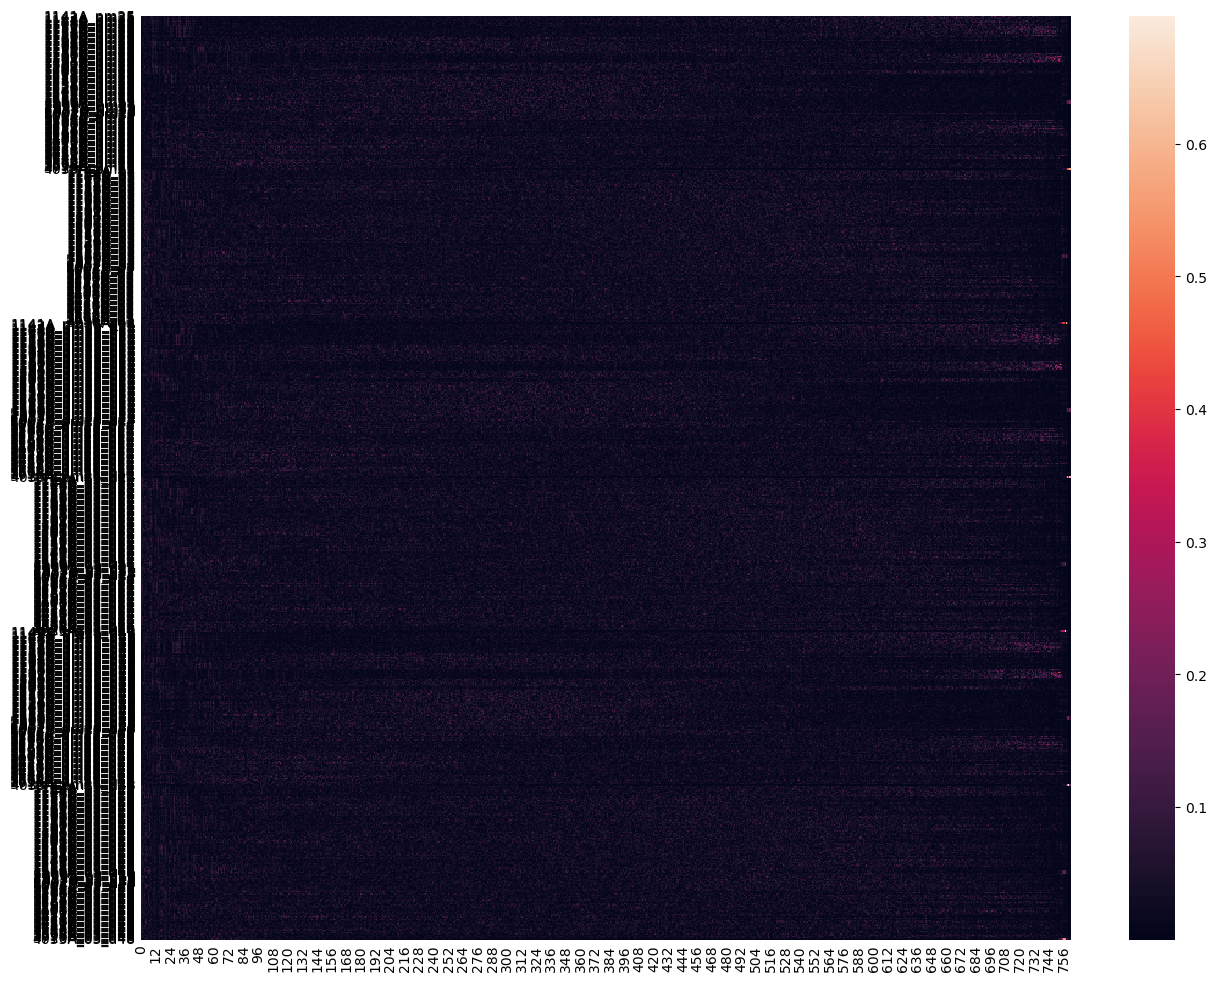

In [37]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=new_names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

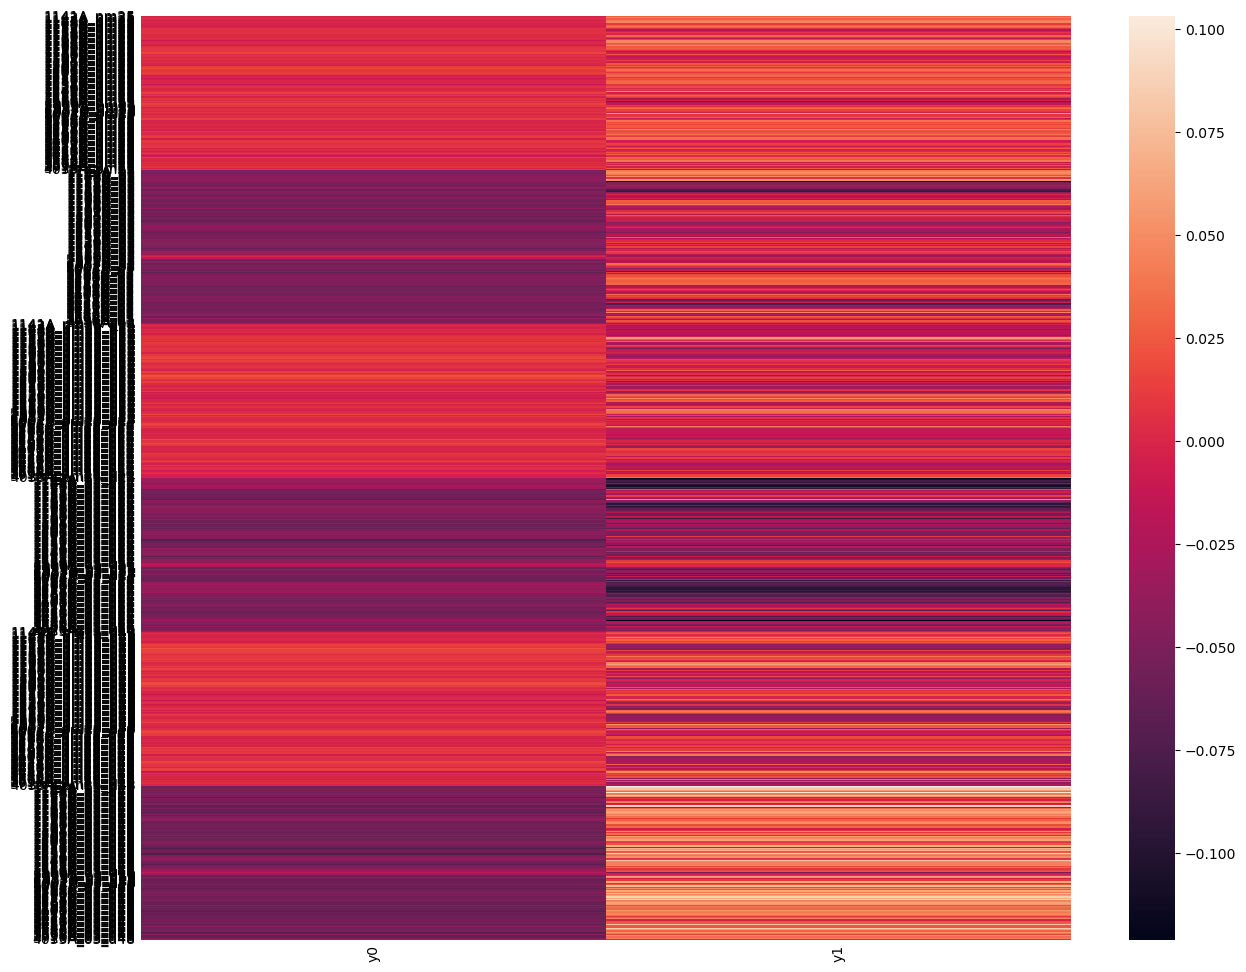

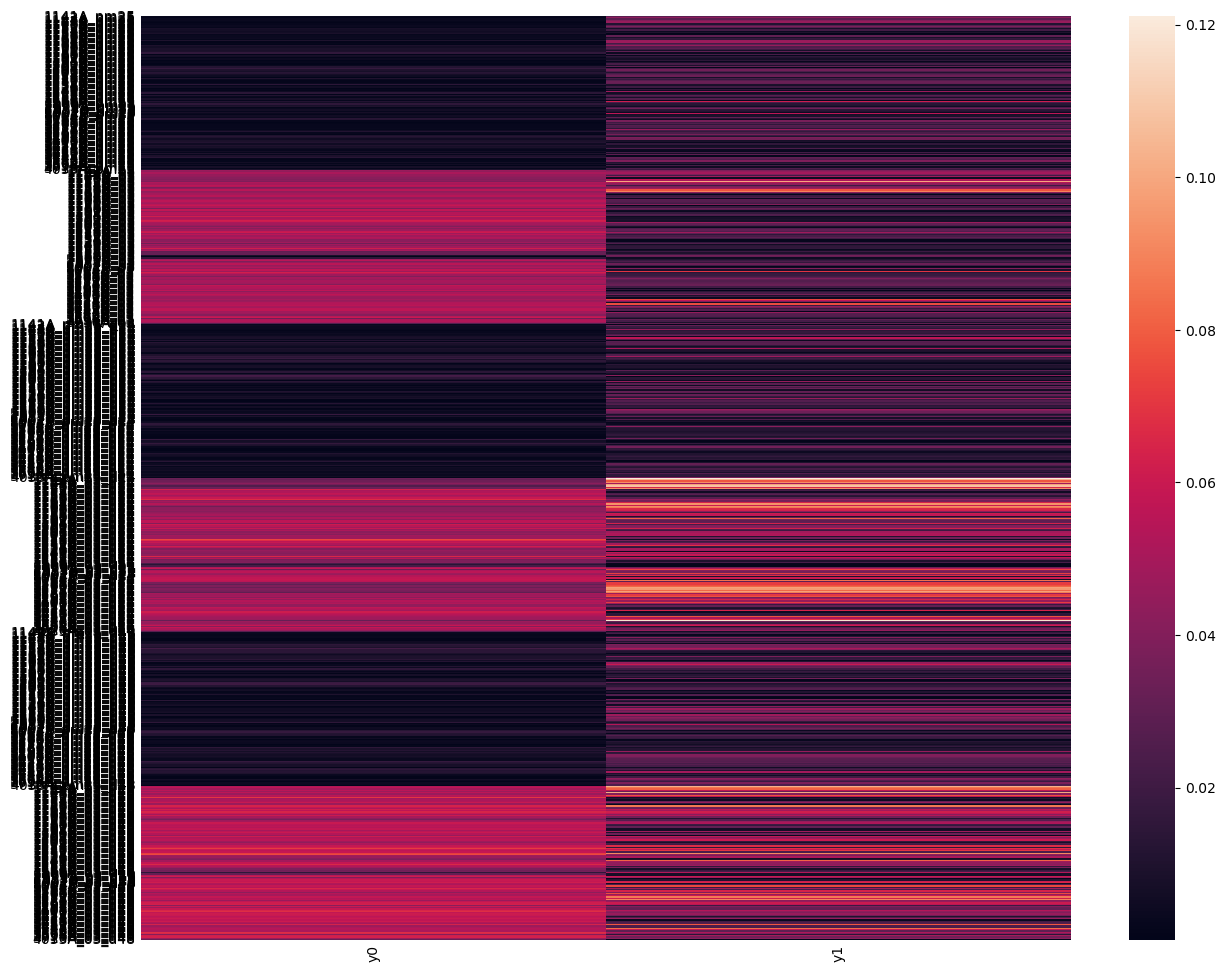

In [38]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=new_names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [39]:
def split_and_group_matrices(U, new_names, n_splits):
    """
    根据变量名筛选行，并将结果矩阵进行 n 等分。
    
    参数:
    U : np.ndarray
        原始大矩阵 (rows x columns)
    new_names : list of str
        对应 U 每一行的名字
    n_splits : int
        每个分类后的矩阵要被切分成几份
        
    返回:
    final_list : list of np.ndarray
        包含所有切分后小矩阵的列表
    """
    
    # 1. 找到对应的行索引
    # 使用列表推导式找到包含特定字符串的索引
    idx_pm25 = [i for i, name in enumerate(new_names) if "pm25" in name]
    idx_o3   = [i for i, name in enumerate(new_names) if "o3" in name]
    
    # 检查是否找到了数据
    if not idx_pm25:
        print("警告: 没有找到包含 'pm25' 的行")
    if not idx_o3:
        print("警告: 没有找到包含 'o3' 的行")
        
    # 2. 根据索引从 U 中提取子矩阵
    # U[list_of_indices, :] 会提取对应的行
    matrix_pm25 = U[idx_pm25, :]
    matrix_o3   = U[idx_o3, :]
    
    # 3. 检查能否被 n 整除 (这是一个常见的坑)
    # 如果不能整除，np.split 会报错，或者我们需要用 array_split
    if matrix_pm25.shape[0] % n_splits != 0:
        print(f"提示: PM2.5 矩阵行数 ({matrix_pm25.shape[0]}) 不能被 {n_splits} 整除，将进行近似均分。")
    if matrix_o3.shape[0] % n_splits != 0:
        print(f"提示: O3 矩阵行数 ({matrix_o3.shape[0]}) 不能被 {n_splits} 整除，将进行近似均分。")

    # 4. 执行拆分
    # np.array_split 比 np.split 更鲁棒，它允许不均匀拆分
    splits_pm25 = np.array_split(matrix_pm25, n_splits, axis=0)
    splits_o3   = np.array_split(matrix_o3,   n_splits, axis=0)
    
    return splits_pm25, splits_o3

splits_pm25, splits_o3 = split_and_group_matrices(U_abs[:, :rank], new_names, n_delays+1)
len(splits_pm25)

3

In [40]:
print("PM2.5" + '-' * 120)
for i,cg in enumerate(splits_pm25):
    plot_station(df, cg, delay=i*delay_interval)

print("O3" + '-' * 120)
for i,cg in enumerate(splits_o3):
    plot_station(df, cg, delay=i*delay_interval)

PM2.5------------------------------------------------------------------------------------------------------------------------


O3------------------------------------------------------------------------------------------------------------------------


In [72]:
coarse_grain_coff = U_abs[:, :rank]
print_equations(coarse_grain_coff, new_names, macro_name)

y0 = 0.2071 * 1223A_o3 + 0.2466 * 1224A_o3 + 0.3859 * 1226A_o3 + 0.5061 * 1227A_o3 + 0.2259 * 1228A_o3 + 0.2219 * 1230A_o3 + 0.1820 * 1231A_o3 + 0.1833 * 1232A_o3 + 0.2221 * 1233A_o3 + 0.0268 * 1247A_o3 + 0.1382 * 1250A_o3 + 0.0061 * 1252A_o3 + 0.0005 * 1253A_o3 + 0.0011 * 2872A_o3 + 0.1294 * 2873A_o3 + 0.0739 * 2907A_o3 + 0.0928 * 2921A_o3 + 0.0016 * 3407A_o3 + 0.0932 * 3408A_o3 + 0.0967 * 3409A_o3 + 0.0204 * 3410A_o3 + 0.0715 * 3411A_o3 + 0.1822 * 3557A_o3 + 0.1268 * 3558A_o3 + 0.0880 * 3560A_o3 + 0.1742 * 3562A_o3 + 0.2383 * 3656A_o3 + 0.1067 * 3658A_o3 + 0.0396 * 1223A_o3_d5 + 0.0502 * 1224A_o3_d5 + 0.1000 * 1226A_o3_d5 + 0.1210 * 1227A_o3_d5 + 0.0435 * 1228A_o3_d5 + 0.0464 * 1230A_o3_d5 + 0.0370 * 1231A_o3_d5 + 0.0424 * 1232A_o3_d5 + 0.0189 * 1233A_o3_d5 + 0.0062 * 1247A_o3_d5 + 0.0215 * 1250A_o3_d5 + 0.0024 * 1252A_o3_d5 + 0.0003 * 1253A_o3_d5 + 0.0005 * 2872A_o3_d5 + 0.0159 * 2873A_o3_d5 + 0.0109 * 2907A_o3_d5 + 0.0145 * 2921A_o3_d5 + 0.0014 * 3407A_o3_d5 + 0.0188 * 3408A_o3_d5 

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_41543/3056197561.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



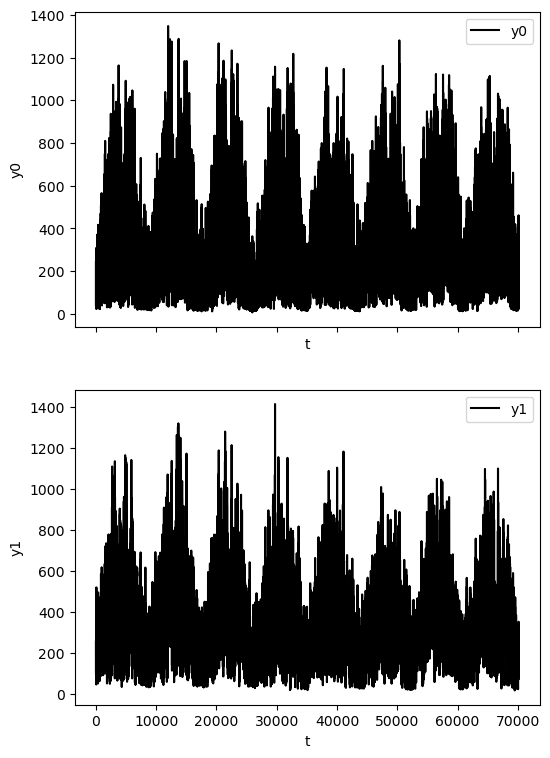

In [73]:
macro_data = H @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

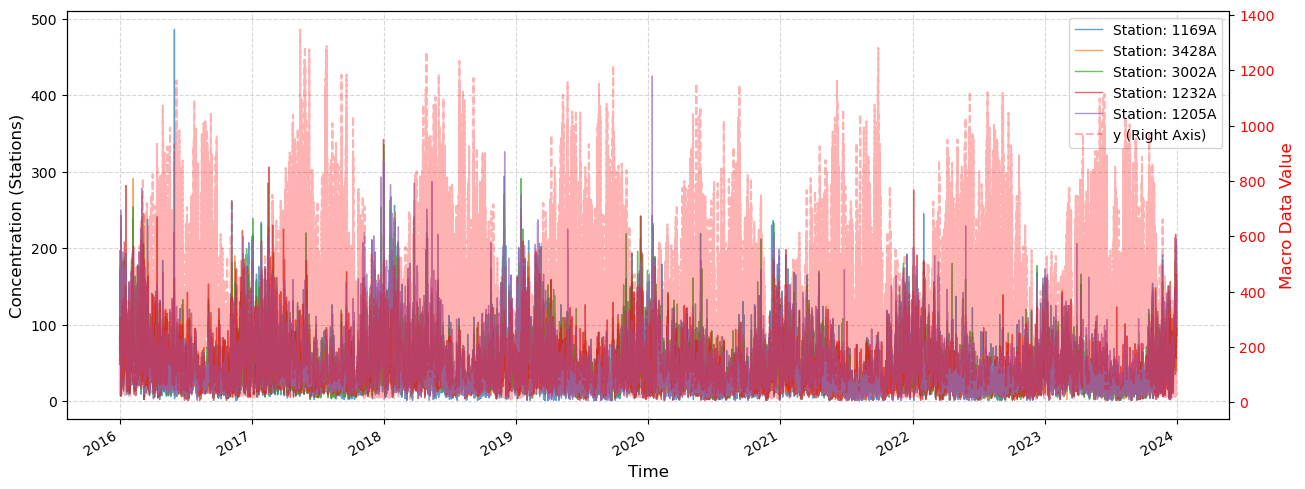

In [77]:
import matplotlib.pyplot as plt

def plot_macro_serie(origin_data, macro_data, n_delays, delay_interval, times, selected_indices, stations):
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # -------------------------------------------------
    # 左侧 Y 轴 (ax1)：绘制各个站点的曲线
    # -------------------------------------------------
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Concentration (Stations)', fontsize=12) # 左轴标签
    ax1.grid(True, linestyle='--', alpha=0.5)
    times_final = times[n_delays*delay_interval:]
    # 循环绘制选定站点的曲线 (画在 ax1 上)
    for idx in selected_indices:
        station_name = stations[idx]
        # 提取数据 (保持原有逻辑)
        station_data = origin_data.isel(station=idx).values[n_delays*delay_interval:]
        
        # 注意这里使用的是 ax1.plot
        ax1.plot(times_final, station_data, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

    # -------------------------------------------------
    # 右侧 Y 轴 (ax2)：绘制最后一条宏观数据线
    # -------------------------------------------------
    ax2 = ax1.twinx()  # 关键步骤：创建共享X轴的第二个Y轴
    ax2.set_ylabel('Macro Data Value', color='red', fontsize=12) # 右轴标签，设为红色以区分
    ax2.tick_params(axis='y', labelcolor='red') # 设置右轴刻度颜色为红色

    # 绘制最后一条线 (画在 ax2 上)
    # 注意这里使用的是 ax2.plot
    ax2.plot(times_final, macro_data, color="red", linestyle='--', alpha=0.3, label=f"y (Right Axis)")

    # -------------------------------------------------
    # 合并图例 (让两个轴的图例显示在一起)
    # -------------------------------------------------
    # 分别获取两个轴的图例句柄和标签
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    # 合并并显示
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

    # 优化时间轴显示
    fig.autofmt_xdate()

    plt.show()

plot_macro_serie(pm25, macro_data[:, 0], n_delays, delay_interval, times, selected_indices, stations)

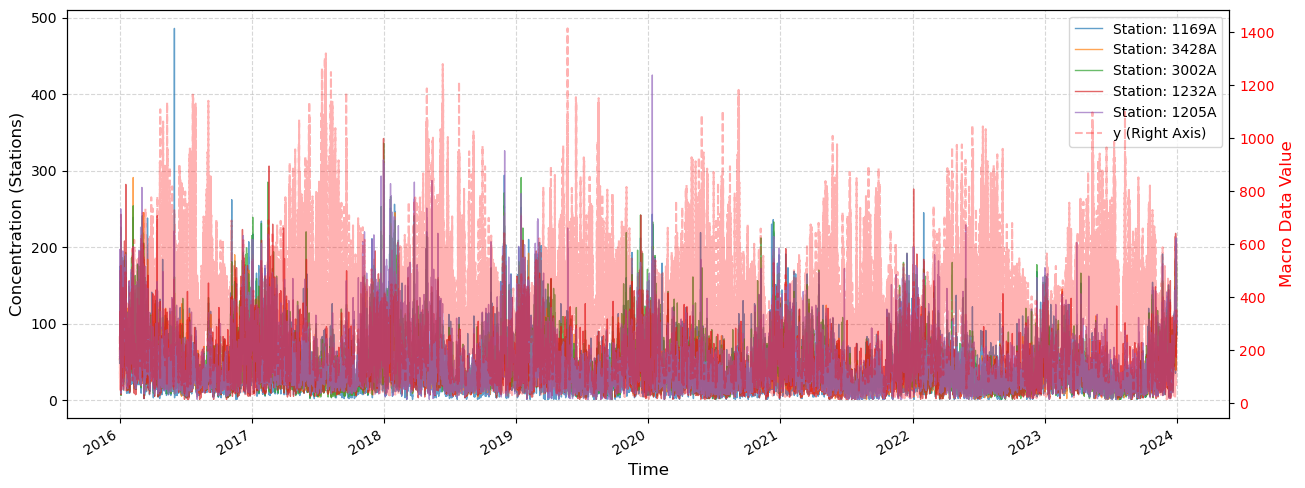

In [78]:
plot_macro_serie(pm25, macro_data[:, 1], n_delays, delay_interval, times, selected_indices, stations)

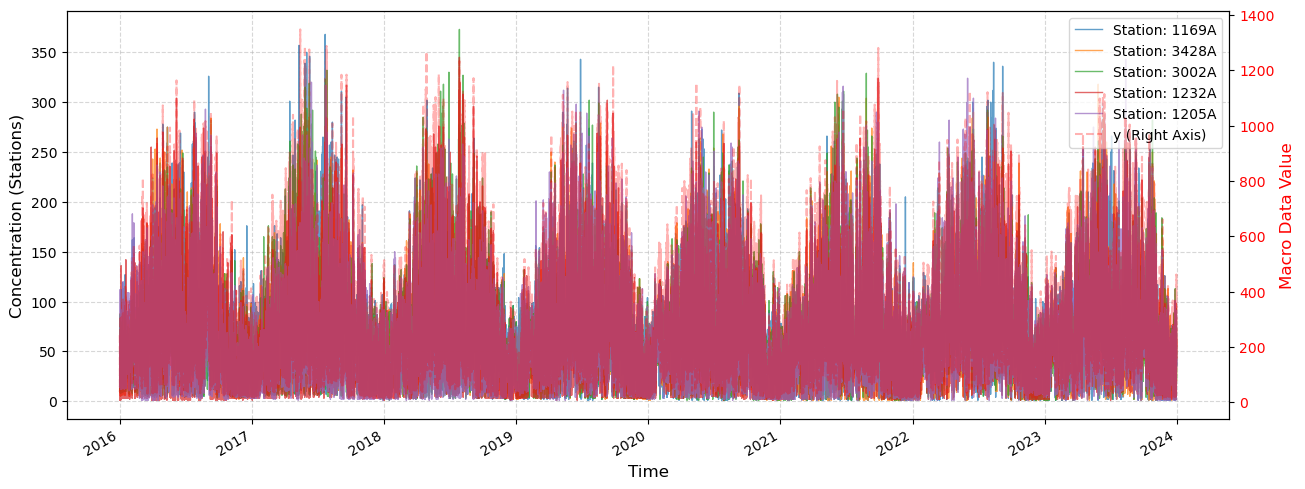

In [79]:
plot_macro_serie(o3, macro_data[:, 0], n_delays, delay_interval, times, selected_indices, stations)